In [1]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import f1_score, classification_report
# import pandas as pd
# import numpy as np

# # Load data
# amplitude_df = pd.read_csv("/kaggle/input/amplifreq/all_signals.csv", header=None)
# frequency_df = pd.read_csv("/kaggle/input/amplifreq/all_frequencies.csv", header=None)

# # Step 1: Prepare amplitude input (X)
# X = amplitude_df.iloc[:, 1:].values.astype(np.float32)  # Keep time column in sync but skip it for training
# X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)  # Normalize each sample

# # Step 2: Prepare frequency labels (y)
# y_raw = frequency_df.iloc[:, 1:].values  # Skip first column only for labeling

# # Extract actual frequency values while keeping time 0s intact
# label_sets = []
# for row in y_raw:
#     freqs = [val for val in row if val not in [0, 50, 150, 250, 350, 450, 550, 650, 750, 881, 950]]  # Keep actual frequency values only
#     label_sets.append(list(set(freqs)))  # Unique labels per row

# # Multi-label binarization
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(label_sets)

# # Step 3: Tensor conversion
# X_tensor = torch.tensor(X)
# y_tensor = torch.tensor(y).float()

# # Step 4: Dataset and Dataloader
# dataset = TensorDataset(X_tensor, y_tensor)
# train_size = int(0.8 * len(dataset))
# train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)

# # Step 5: Define model
# class FrequencyClassifier(nn.Module):
#     def __init__(self, input_size, num_labels):
#         super(FrequencyClassifier, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, 512),
#             nn.ReLU(),
#             nn.BatchNorm1d(512),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_labels),
#             nn.Sigmoid()  # Multi-label classification
#         )

#     def forward(self, x):
#         return self.net(x)

# # Initialize model
# model = FrequencyClassifier(X.shape[1], y.shape[1])
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Step 6: Training loop
# for epoch in range(350):
#     model.train()
#     total_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}/20, Loss: {total_loss / len(train_loader):.4f}")

# # Step 7: Evaluation
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         preds = (outputs > 0.5).int()
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())

# f1 = f1_score(all_labels, all_preds, average='micro')
# print(f"\nMicro F1 Score: {f1:.4f}")
# print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[str(label) for label in mlb.classes_]))


In [2]:
# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

Epoch 1/50 | Loss: 0.2521 | Train F1: 0.1269 | Train Acc (1% err): 0.0612
Epoch 2/50 | Loss: 0.0349 | Train F1: 0.7189 | Train Acc (1% err): 0.5687
Epoch 3/50 | Loss: 0.0264 | Train F1: 0.8187 | Train Acc (1% err): 0.7825
Epoch 4/50 | Loss: 0.0235 | Train F1: 0.8484 | Train Acc (1% err): 0.8438
Epoch 5/50 | Loss: 0.0218 | Train F1: 0.8616 | Train Acc (1% err): 0.8875
Epoch 6/50 | Loss: 0.0196 | Train F1: 0.8710 | Train Acc (1% err): 0.8944
Epoch 7/50 | Loss: 0.0189 | Train F1: 0.8763 | Train Acc (1% err): 0.9050
Epoch 8/50 | Loss: 0.0176 | Train F1: 0.8832 | Train Acc (1% err): 0.9281
Epoch 9/50 | Loss: 0.0164 | Train F1: 0.8884 | Train Acc (1% err): 0.9363
Epoch 10/50 | Loss: 0.0157 | Train F1: 0.8908 | Train Acc (1% err): 0.9487
Epoch 11/50 | Loss: 0.0150 | Train F1: 0.8926 | Train Acc (1% err): 0.9350
Epoch 12/50 | Loss: 0.0139 | Train F1: 0.8993 | Train Acc (1% err): 0.9487
Epoch 13/50 | Loss: 0.0139 | Train F1: 0.8951 | Train Acc (1% err): 0.9337
Epoch 14/50 | Loss: 0.0132 | Train

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

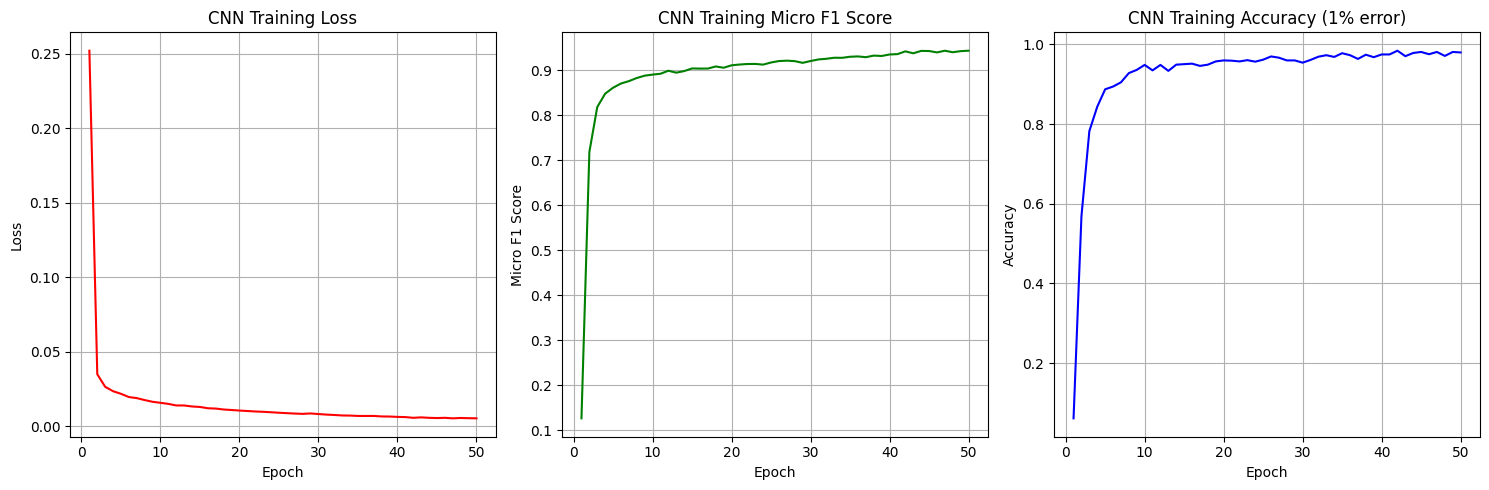

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------
# Load and preprocess data
# ----------------------
amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)

X_tensor = torch.tensor(X).unsqueeze(1)  # shape: [N, 1, T]
y_tensor = torch.tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# ----------------------
# Define CNN model
# ----------------------
class CNNClassifier(nn.Module):
    def __init__(self, input_length, num_labels):
        super(CNNClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.flatten_dim = (input_length // 4) * 64
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ----------------------
# Training
# ----------------------
model_CNN = CNNClassifier(input_length=X.shape[1], num_labels=y.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

num_epochs = 50
cnn_train_losses = []
cnn_train_f1_scores = []
cnn_train_accuracies = []

for epoch in range(num_epochs):
    model_CNN.train()
    total_loss = 0
    all_preds, all_labels = [], []
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        mismatches = (preds != labels).sum(dim=1)
        allowed_error = int(0.01 * labels.size(1))
        correct += (mismatches <= allowed_error).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='micro')
    train_acc = correct / total

    cnn_train_losses.append(avg_loss)
    cnn_train_f1_scores.append(train_f1)
    cnn_train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc (1% err): {train_acc:.4f}")

# ----------------------
# Final Testing Evaluation
# ----------------------
model_CNN.eval()
all_preds_CNN, all_labels_CNN, comparison_rows_CNN = [], [], []
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_CNN(inputs)
        preds = (outputs > 0.5).float()

        all_preds_CNN.extend(preds.cpu().numpy())
        all_labels_CNN.extend(labels.cpu().numpy())

        for p, t in zip(preds, labels):
            pred_labels = [mlb.classes_[i] for i, v in enumerate(p) if v == 1]
            true_labels = [mlb.classes_[i] for i, v in enumerate(t) if v == 1]
            comparison_rows_CNN.append({"Predicted": pred_labels, "True": true_labels})

        mismatches = (preds != labels).sum(dim=1)
        allowed_error = int(0.01 * labels.size(1))
        correct += (mismatches <= allowed_error).sum().item()
        total += labels.size(0)

test_f1_CNN = f1_score(all_labels_CNN, all_preds_CNN, average='micro')
test_acc_CNN = correct / total

print(f"\n✅ Final Test Micro F1 Score (CNN): {test_f1_CNN:.4f}")
print(f"✅ Final Test Accuracy (1% error) (CNN): {test_acc_CNN:.4f}")

print("\n📋 Classification Report (CNN):")
print(classification_report(all_labels_CNN, all_preds_CNN, target_names=[str(l) for l in mlb.classes_]))

# ----------------------
# Save Predictions
# ----------------------
pd.DataFrame(comparison_rows_CNN).to_csv("cnn_prediction_vs_ground_truth_test.csv", index=False)

# ----------------------
# Plot Loss, F1 and Accuracy
# ----------------------
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), cnn_train_losses, label="Train Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), cnn_train_f1_scores, label="Train Micro F1", color='green')
plt.xlabel("Epoch")
plt.ylabel("Micro F1 Score")
plt.title("CNN Training Micro F1 Score")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), cnn_train_accuracies, label="Train Accuracy (1% error)", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Training Accuracy (1% error)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
# import pandas as pd

# model.eval()
# all_preds = []
# all_labels = []
# comparison_rows = []

# threshold = 0.5  # You can tune this

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         probs = outputs  # Already sigmoid from model
#         preds = (probs > threshold).int()
        
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())
        
#         # Record comparison
#         for p, t in zip(preds, labels):
#             pred_labels = [mlb.classes_[i] for i, val in enumerate(p) if val == 1]
#             true_labels = [mlb.classes_[i] for i, val in enumerate(t) if val == 1]
#             comparison_rows.append({
#                 "Predicted": pred_labels,
#                 "True": true_labels
#             })

# # Show F1 score
# from sklearn.metrics import f1_score
# f1 = f1_score(all_labels, all_preds, average='micro')
# print(f"Micro F1 Score: {f1:.4f}")

# # Convert comparisons to a DataFrame for easier viewing
# comparison_df = pd.DataFrame(comparison_rows)
# print(comparison_df.head(10))  # Show first 10 predictions and ground truths


# comparison_df.to_csv("prediction_vs_ground_truth.csv", index=False)


In [5]:
# import shutil

# # Move CSV to /kaggle/working if it's not already there
# shutil.move("prediction_vs_ground_truth.csv", "/kaggle/working/prediction_vs_ground_truth.csv")


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Epoch 1/50 | Loss: 0.1564 | Train F1: 0.2871 | Train Acc (1% tol): 0.3281
Epoch 2/50 | Loss: 0.0436 | Train F1: 0.7514 | Train Acc (1% tol): 0.6362
Epoch 3/50 | Loss: 0.0274 | Train F1: 0.7957 | Train Acc (1% tol): 0.7181
Epoch 4/50 | Loss: 0.0250 | Train F1: 0.8117 | Train Acc (1% tol): 0.7544
Epoch 5/50 | Loss: 0.0240 | Train F1: 0.8250 | Train Acc (1% tol): 0.7681
Epoch 6/50 | Loss: 0.0230 | Train F1: 0.8305 | Train Acc (1% tol): 0.7869
Epoch 7/50 | Loss: 0.0222 | Train F1: 0.8430 | Train Acc (1% tol): 0.7937
Epoch 8/50 | Loss: 0.0209 | Train F1: 0.8532 | Train Acc (1% tol): 0.8363
Epoch 9/50 | Loss: 0.0195 | Train F1: 0.8615 | Train Acc (1% tol): 0.8588
Epoch 10/50 | Loss: 0.0179 | Train F1: 0.8738 | Train Acc (1% tol): 0.8938
Epoch 11/50 | Loss: 0.0169 | Train F1: 0.8777 | Train Acc (1% tol): 0.8938
Epoch 12/50 | Loss: 0.0155 | Train F1: 0.8883 | Train Acc (1% tol): 0.9219
Epoch 13/50 | Loss: 0.0146 | Train F1: 0.8941 | Train Acc (1% tol): 0.9387
Epoch 14/50 | Loss: 0.0135 | Train

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

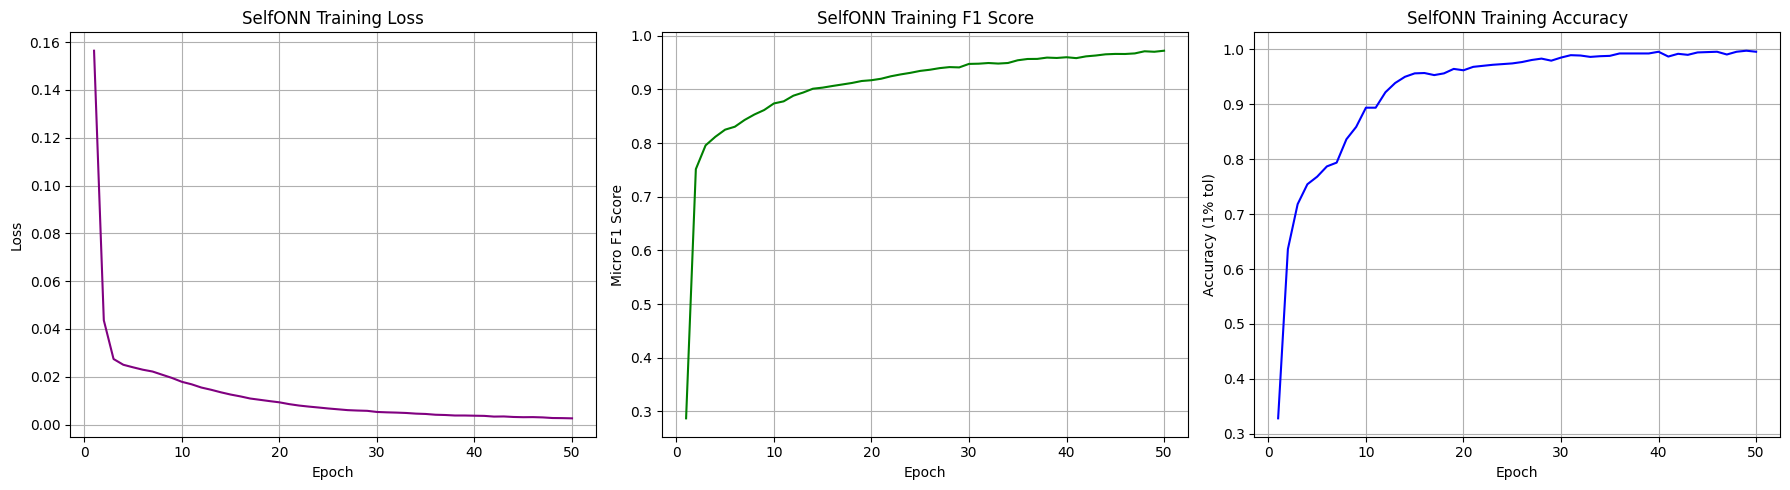

In [7]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 📂 Load Data
amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

# 🎛️ Normalize Inputs
X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

# 🎛️ Label Preprocessing
y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)

# 📦 Tensors
X_tensor = torch.tensor(X).unsqueeze(1)
y_tensor = torch.tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 🧱 SelfONN Layer
class SelfONNLayer1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, order=3, stride=1, padding=0):
        super().__init__()
        self.order = order
        self.weights = nn.ParameterList([
            nn.Parameter(torch.randn(out_channels, in_channels, kernel_size))
            for _ in range(order)
        ])
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        out = 0
        for k in range(self.order):
            out += nn.functional.conv1d(x ** (k + 1), self.weights[k], bias=None,
                                        stride=self.stride, padding=self.padding)
        out += self.bias.view(1, -1, 1)
        return out

# 🧱 SelfONN Classifier
class SelfONNClassifier(nn.Module):
    def __init__(self, input_length, num_labels, order=3):
        super().__init__()
        self.conv1 = SelfONNLayer1D(1, 32, kernel_size=5, order=order, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = SelfONNLayer1D(32, 64, kernel_size=3, order=order, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        flat_dim = (input_length // 4) * 64
        self.fc1 = nn.Linear(flat_dim, 256)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(256, num_labels)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.drop(x)
        return torch.sigmoid(self.out(x))

# ⚙️ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_SelfONN = SelfONNClassifier(input_length=X.shape[1], num_labels=y.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_SelfONN.parameters(), lr=0.001)

# 📊 Trackers
num_epochs = 50
sonn_train_losses = []
sonn_train_f1_scores = []
sonn_train_accuracies = []

start_time = time.time()

# 🏋️ Training Loop
for epoch in range(num_epochs):
    model_SelfONN.train()
    total_loss = 0
    all_preds, all_labels = [], []
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_SelfONN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = int(0.01 * labels.size(1))
        correct += (mismatches <= allowed_errors).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    train_f1 = f1_score(all_labels, all_preds, average='micro')
    train_acc = correct / total

    sonn_train_losses.append(avg_loss)
    sonn_train_f1_scores.append(train_f1)
    sonn_train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc (1% tol): {train_acc:.4f}")

end_time = time.time()

# 🧪 Final Testing
model_SelfONN.eval()
all_preds_SelfONN, all_labels_SelfONN = [], []
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_SelfONN(inputs)
        preds = (outputs > 0.5).float()

        all_preds_SelfONN.extend(preds.cpu().numpy())
        all_labels_SelfONN.extend(labels.cpu().numpy())

        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = int(0.01 * labels.size(1))
        correct += (mismatches <= allowed_errors).sum().item()
        total += labels.size(0)

test_f1_SelfONN = f1_score(all_labels_SelfONN, all_preds_SelfONN, average='micro')
test_acc_SelfONN = correct / total

print(f"\n✅ Final Test Micro F1 Score (SelfONN): {test_f1_SelfONN:.4f}")
print(f"✅ Final Test Accuracy (1% tol) (SelfONN): {test_acc_SelfONN:.4f}")
print(f"⏱️ Total Training Time: {end_time - start_time:.2f} seconds\n")

print("📋 Classification Report (SelfONN):\n")
print(classification_report(all_labels_SelfONN, all_preds_SelfONN, target_names=[str(l) for l in mlb.classes_]))

# 📈 Plot
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), sonn_train_losses, color='purple')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SelfONN Training Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), sonn_train_f1_scores, color='green')
plt.xlabel("Epoch")
plt.ylabel("Micro F1 Score")
plt.title("SelfONN Training F1 Score")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), sonn_train_accuracies, color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (1% tol)")
plt.title("SelfONN Training Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# pip install snntorch


In [9]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import f1_score, classification_report
# import pandas as pd
# import numpy as np
# import snntorch as snn
# from snntorch import surrogate
# from snntorch import functional as SF

# # Load and normalize data
# amplitude_df = pd.read_csv("/kaggle/input/amplifreq/all_signals.csv", header=None)
# frequency_df = pd.read_csv("/kaggle/input/amplifreq/all_frequencies.csv", header=None)

# X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
# X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)
# y_raw = frequency_df.iloc[:, 1:].values
# label_sets = [list(set(row[row != 0])) for row in y_raw]
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(label_sets)

# X_tensor = torch.tensor(X).unsqueeze(1)  # (B, C=1, T)
# y_tensor = torch.tensor(y).float()

# dataset = TensorDataset(X_tensor, y_tensor)
# train_size = int(0.8 * len(dataset))
# train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)

# # SNN Classifier
# class SNNClassifier(nn.Module):
#     def __init__(self, input_length, num_labels, time_window=20):
#         super().__init__()
#         self.time_window = time_window
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
#         self.lif1 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())

#         self.pool1 = nn.MaxPool1d(2)

#         self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
#         self.lif2 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())
#         self.pool2 = nn.MaxPool1d(2)

#         flat_dim = (input_length // 4) * 64
#         self.fc1 = nn.Linear(flat_dim, 256)
#         self.lif3 = snn.Leaky(beta=0.95, spike_grad=surrogate.fast_sigmoid())

#         self.fc2 = nn.Linear(256, num_labels)

#     def forward(self, x):
#         spk_rec = []
#         mem1 = mem2 = mem3 = 0

#         for step in range(self.time_window):
#             cur_input = x + torch.rand_like(x) * 0.01  # small noise simulating input variation

#             x1 = self.conv1(cur_input)
#             spk1, mem1 = self.lif1(x1, mem1)
#             x1 = self.pool1(spk1)

#             x2 = self.conv2(x1)
#             spk2, mem2 = self.lif2(x2, mem2)
#             x2 = self.pool2(spk2)

#             x2 = x2.view(x2.size(0), -1)
#             x3 = self.fc1(x2)
#             spk3, mem3 = self.lif3(x3, mem3)

#             out = self.fc2(spk3)
#             spk_rec.append(out)

#         spk_rec = torch.stack(spk_rec, dim=0)  # (time, batch, labels)
#         out_rate = spk_rec.mean(dim=0)  # firing rate
#         return torch.sigmoid(out_rate)

# # Instantiate model
# input_length = X.shape[1]
# num_labels = y.shape[1]
# model = SNNClassifier(input_length=input_length, num_labels=num_labels, time_window=20)

# # Training Setup
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# for epoch in range(20):  # Reduce epochs due to longer simulation
#     model.train()
#     total_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# # Evaluation
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         preds = (outputs > 0.5).int()
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())

# f1 = f1_score(all_labels, all_preds, average='micro')
# print(f"Micro F1 Score: {f1:.4f}")
# print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))


Epoch 01: Train Loss=0.0878, F1=0.3971, Acc(≤1%)=0.4113
Epoch 02: Train Loss=0.0235, F1=0.8324, Acc(≤1%)=0.7806
Epoch 03: Train Loss=0.0184, F1=0.8780, Acc(≤1%)=0.8931
Epoch 04: Train Loss=0.0157, F1=0.8949, Acc(≤1%)=0.9369
Epoch 05: Train Loss=0.0134, F1=0.9082, Acc(≤1%)=0.9606
Epoch 06: Train Loss=0.0115, F1=0.9148, Acc(≤1%)=0.9750
Epoch 07: Train Loss=0.0098, F1=0.9249, Acc(≤1%)=0.9844
Epoch 08: Train Loss=0.0083, F1=0.9314, Acc(≤1%)=0.9888
Epoch 09: Train Loss=0.0072, F1=0.9380, Acc(≤1%)=0.9925
Epoch 10: Train Loss=0.0060, F1=0.9463, Acc(≤1%)=0.9888
Epoch 11: Train Loss=0.0051, F1=0.9518, Acc(≤1%)=0.9962
Epoch 12: Train Loss=0.0044, F1=0.9586, Acc(≤1%)=0.9988
Epoch 13: Train Loss=0.0039, F1=0.9627, Acc(≤1%)=0.9950
Epoch 14: Train Loss=0.0033, F1=0.9709, Acc(≤1%)=0.9994
Epoch 15: Train Loss=0.0029, F1=0.9744, Acc(≤1%)=0.9981
Epoch 16: Train Loss=0.0025, F1=0.9787, Acc(≤1%)=0.9994
Epoch 17: Train Loss=0.0024, F1=0.9815, Acc(≤1%)=0.9988
Epoch 18: Train Loss=0.0022, F1=0.9831, Acc(≤1%)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

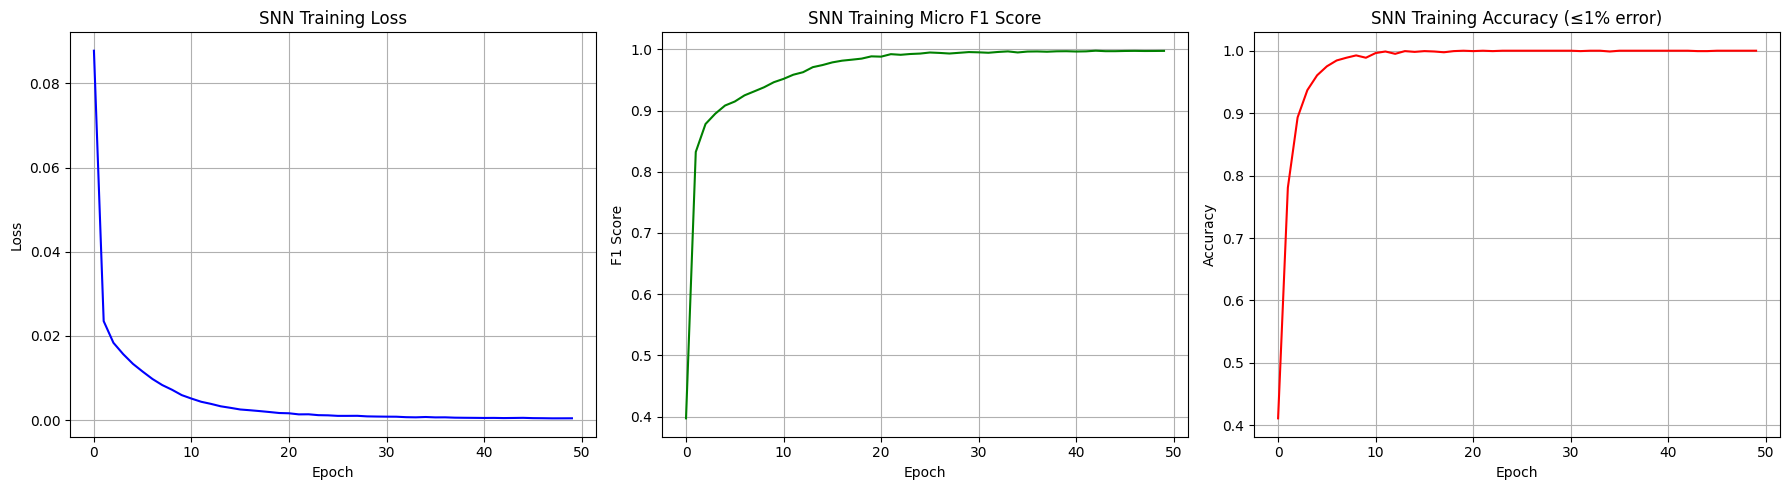

In [10]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 📂 Load and preprocess data
amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

X = amplitude_df.iloc[:, 1:].values.astype(np.float32)
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

y_raw = frequency_df.iloc[:, 1:].values
label_sets = [list(set(row[row != 0])) for row in y_raw]
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(label_sets)

X_tensor = torch.tensor(X).unsqueeze(1)
y_tensor = torch.tensor(y).float()

# Optional: use smaller sample
X_tensor = X_tensor[:2000]
y_tensor = y_tensor[:2000]

# Dataset split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 🧱 LIF Neuron
class LIFNeuron(nn.Module):
    def __init__(self, threshold=1.0, decay=0.9):
        super().__init__()
        self.threshold = threshold
        self.decay = decay

    def forward(self, x):
        batch_size, channels, time = x.size()
        mem = torch.zeros(batch_size, channels, device=x.device)
        spikes = []

        for t in range(time):
            input_t = x[:, :, t]
            mem = self.decay * mem + input_t
            spike = (mem >= self.threshold).float()
            mem = mem * (1 - spike)
            spikes.append(spike.unsqueeze(-1))

        return torch.cat(spikes, dim=-1)

# 🧱 SNN Classifier
class SNNClassifier(nn.Module):
    def __init__(self, input_length, num_labels):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.lif1 = LIFNeuron()
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.lif2 = LIFNeuron()
        self.pool2 = nn.MaxPool1d(2)

        flat_dim = (input_length // 4) * 64
        self.fc1 = nn.Linear(flat_dim, 256)
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(256, num_labels)

    def forward(self, x):
        x = self.pool1(self.lif1(self.conv1(x)))
        x = self.pool2(self.lif2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        return torch.sigmoid(self.out(x))

# ⚙️ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_SNN = SNNClassifier(X_tensor.shape[2], y_tensor.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_SNN.parameters(), lr=0.001)

# 📊 Metrics
num_epochs = 50
snn_train_losses = []
snn_train_f1_scores = []
snn_train_accuracies = []

start_time = time.time()

# 🏋️ Training Loop
for epoch in range(num_epochs):
    model_SNN.train()
    total_loss = 0
    all_preds_SNN, all_labels_SNN = [], []
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_SNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = (outputs > 0.5).float()
        all_preds_SNN.extend(preds.cpu().numpy())
        all_labels_SNN.extend(labels.cpu().numpy())

        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = int(0.01 * labels.size(1))
        correct += (mismatches <= allowed_errors).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    f1 = f1_score(all_labels_SNN, all_preds_SNN, average='micro')
    acc = correct / total

    snn_train_losses.append(avg_loss)
    snn_train_f1_scores.append(f1)
    snn_train_accuracies.append(acc)

    print(f"Epoch {epoch+1:02d}: Train Loss={avg_loss:.4f}, F1={f1:.4f}, Acc(≤1%)={acc:.4f}")

# 🧪 Final Test Evaluation
model_SNN.eval()
all_preds_SNN, all_labels_SNN = [], []
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_SNN(inputs)
        preds = (outputs > 0.5).float()

        all_preds_SNN.extend(preds.cpu().numpy())
        all_labels_SNN.extend(labels.cpu().numpy())

        mismatches = (preds != labels).sum(dim=1)
        allowed_errors = int(0.01 * labels.size(1))
        correct += (mismatches <= allowed_errors).sum().item()
        total += labels.size(0)

test_f1_SNN = f1_score(all_labels_SNN, all_preds_SNN, average='micro')
test_acc_SNN = correct / total
training_time_SNN = time.time() - start_time

print(f"\n✅ Final Test Micro F1 Score (SNN): {test_f1_SNN:.4f}")
print(f"✅ Final Test Accuracy (≤1% Error) (SNN): {test_acc_SNN:.4f}")
print(f"⏱️ Total Training Time: {training_time_SNN:.2f} seconds\n")

print("Classification Report (SNN):\n")
print(classification_report(all_labels_SNN, all_preds_SNN, target_names=[str(l) for l in mlb.classes_]))

# 📈 Plotting
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(snn_train_losses, color='blue')
plt.title("SNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(snn_train_f1_scores, color='green')
plt.title("SNN Training Micro F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(snn_train_accuracies, color='red')
plt.title("SNN Training Accuracy (≤1% error)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


In [11]:
amplitude_df.shape

(2000, 801)

In [12]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset, random_split
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import f1_score, classification_report
# import pandas as pd
# import numpy as np

# # ------------------------------
# # 1. Load and Normalize Data
# # ------------------------------
# amplitude_df = pd.read_csv("/kaggle/input/secound/all_signals_1.csv", header=None)
# frequency_df = pd.read_csv("/kaggle/input/secound/all_frequencies_1.csv", header=None)

# X = amplitude_df.iloc[:, 1:].values.astype(np.float32)  # Skip timestamp column
# X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-6)

# # ------------------------------
# # 2. Pad/Truncate and Reshape to (N, 1, 128, 128)
# # ------------------------------
# target_len = 128 * 128
# X_fixed = []

# for row in X:
#     if len(row) < target_len:
#         padded = np.pad(row, (0, target_len - len(row)), mode='constant')
#     else:
#         padded = row[:target_len]
#     X_fixed.append(padded)

# X_fixed = np.array(X_fixed).reshape(-1, 1, 128, 128).astype(np.float32)

# # ------------------------------
# # 3. Prepare Multi-Label Targets
# # ------------------------------
# y_raw = frequency_df.iloc[:, 1:].values  # Skip timestamp column
# label_sets = [list(set(row[row != 0])) for row in y_raw]

# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(label_sets)

# # ------------------------------
# # 4. Create Datasets and Loaders
# # ------------------------------
# X_tensor = torch.tensor(X_fixed)
# y_tensor = torch.tensor(y).float()

# dataset = TensorDataset(X_tensor, y_tensor)
# train_size = int(0.8 * len(dataset))
# train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # ------------------------------
# # 5. Define CNN-based Multi-Label Classifier
# # ------------------------------
# class CNNFrequencyClassifier(nn.Module):
#     def __init__(self, num_classes):
#         super(CNNFrequencyClassifier, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 8, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(8, 16, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(32 * 16 * 16, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_classes),
#             nn.Sigmoid()  # For multi-label classification
#         )

#     def forward(self, x):
#         x = self.features(x)
#         return self.classifier(x)

# model = CNNFrequencyClassifier(num_classes=y.shape[1])
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # ------------------------------
# # 6. Training Loop
# # ------------------------------
# for epoch in range(10):  # You can increase if needed
#     model.train()
#     total_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch + 1}/10, Loss: {total_loss / len(train_loader):.4f}")


# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in val_loader:
#         outputs = model(inputs)
#         preds = (outputs > 0.5).int()
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# f1 = f1_score(all_labels, all_preds, average='micro')
# print(f"\n✅ Micro F1 Score: {f1:.4f}")
# print("\n📋 Classification Report:\n", classification_report(all_labels, all_preds, target_names=[str(l) for l in mlb.classes_]))


In [13]:
import numpy as np
import pandas as pd

def run_topsis(df, weights, impacts):
    # Step 1: Prepare decision matrix (excluding the first column i.e., Model)
    decision_matrix = df.iloc[:, 1:].values.astype(np.float64)

    # Step 2: Normalize the decision matrix (vector normalization)
    norm = np.linalg.norm(decision_matrix, axis=0)
    norm[norm == 0] = 1e-10  # Prevent divide-by-zero
    norm_matrix = decision_matrix / norm

    # Step 3: Apply weights
    weights = np.array(weights)
    weighted_matrix = norm_matrix * weights

    # Step 4: Determine ideal and negative-ideal solutions
    ideal, negative_ideal = [], []
    for i, impact in enumerate(impacts):
        if impact == '+':
            ideal.append(np.max(weighted_matrix[:, i]))
            negative_ideal.append(np.min(weighted_matrix[:, i]))
        else:
            ideal.append(np.min(weighted_matrix[:, i]))
            negative_ideal.append(np.max(weighted_matrix[:, i]))
    ideal = np.array(ideal)
    negative_ideal = np.array(negative_ideal)

    # Step 5: Compute distances to ideal and negative ideal
    dist_ideal = np.linalg.norm(weighted_matrix - ideal, axis=1)
    dist_negative = np.linalg.norm(weighted_matrix - negative_ideal, axis=1)

    # Step 6: Compute relative closeness (safe division)
    denom = dist_ideal + dist_negative
    denom[denom == 0] = 1e-10  # Avoid division by zero
    closeness = dist_negative / denom

    # Step 7 & 8: Score and Rank
    df['TOPSIS Score'] = closeness
    df['Rank'] = df['TOPSIS Score'].rank(ascending=False, method='min').fillna(len(df)).astype(int)
    df = df.sort_values(by='TOPSIS Score', ascending=False).reset_index(drop=True)
    
    return df


In [14]:
cnn_accuracy = test_acc_CNN
cnn_f1       = test_f1_CNN
sonn_accuracy = test_acc_SelfONN
sonn_f1       = test_f1_SelfONN
snn_accuracy = test_acc_SNN
snn_f1       = test_f1_SNN

data = {
    'Model': ['SONN', 'CNN', 'SNN'],
    'Accuracy': [sonn_accuracy, cnn_accuracy, snn_accuracy],
    'F1 Score': [sonn_f1, cnn_f1, snn_f1],
}
df = pd.DataFrame(data)

weights = [0.6, 0.4]
impacts = ['+', '+']

result_df = run_topsis(df, weights, impacts)
print("\n TOPSIS Ranking:\n")
print(result_df)



 TOPSIS Ranking:

  Model  Accuracy  F1 Score  TOPSIS Score  Rank
0   CNN    0.9825  0.926210      1.000000     1
1  SONN    0.9775  0.925734      0.776342     2
2   SNN    0.9725  0.902260      0.000000     3


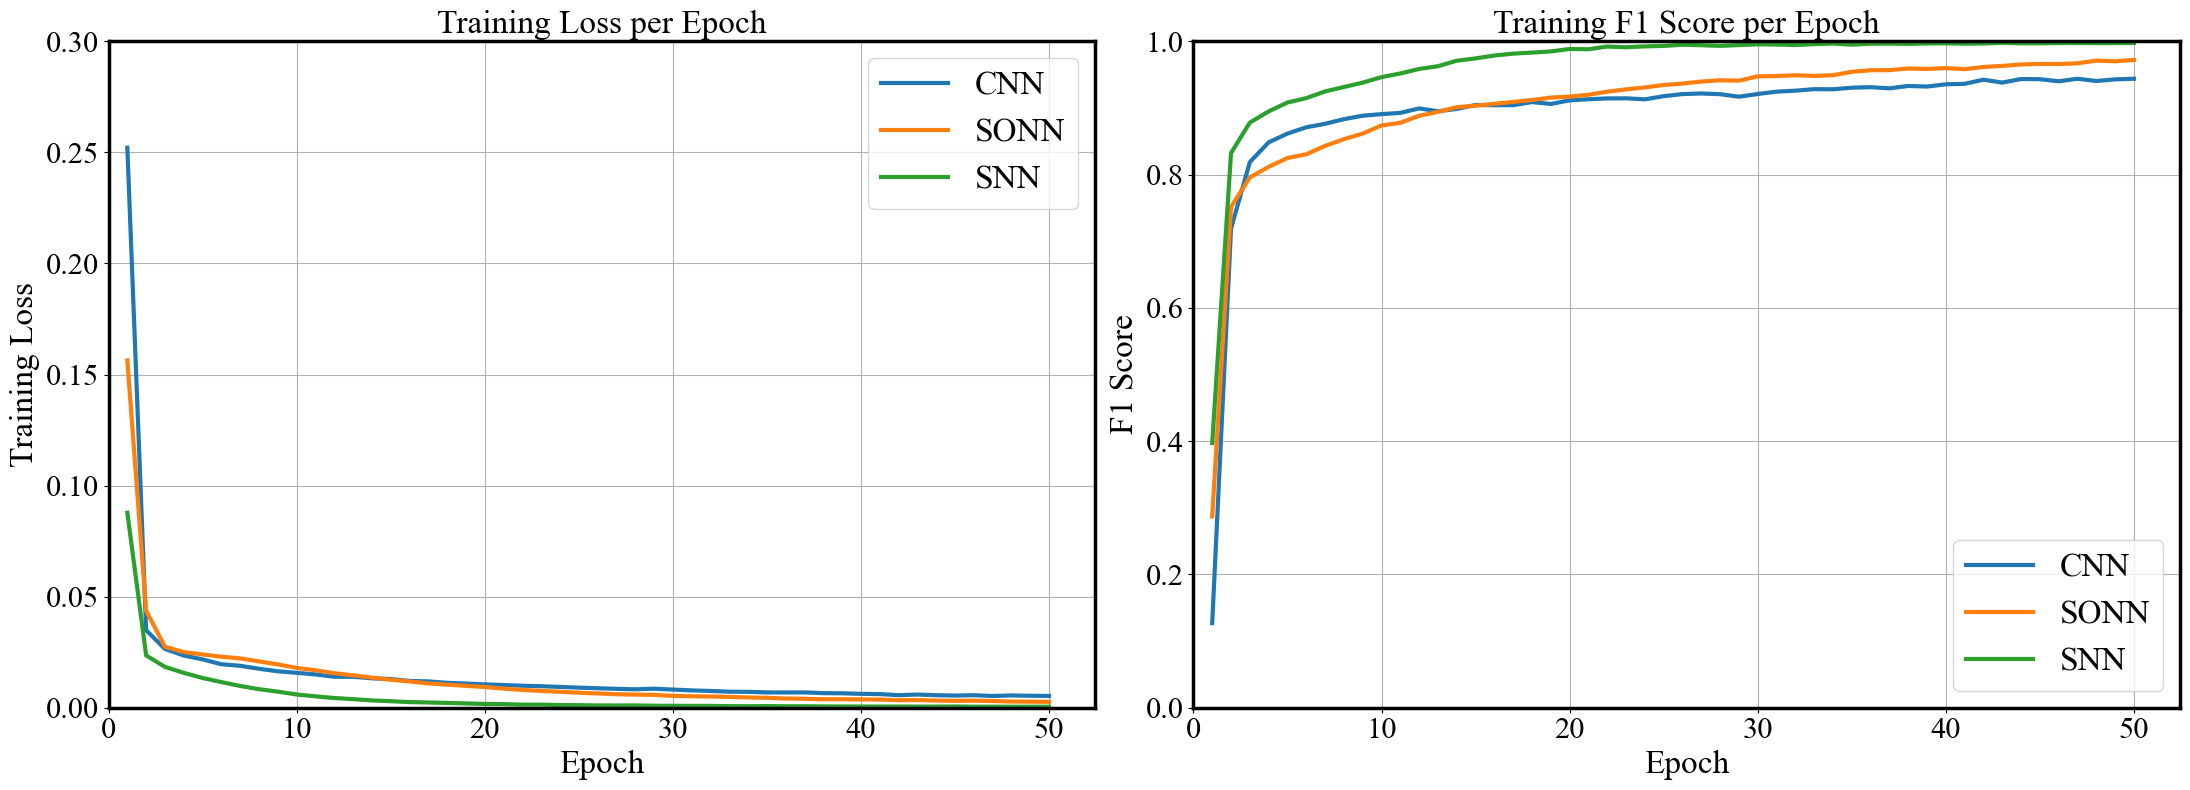

In [15]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm

# 📌 Load Times New Roman font
font_path = "/kaggle/input/d/neeltiwary/times-roman/Times New Roman Font.ttf"
tnr_font = fm.FontProperties(fname=font_path, size=20)
tnr_bold_font = fm.FontProperties(fname=font_path, size=24)

# 📊 Epochs
epochs = range(1, 51)

# 🔁 Replace with your actual training log data
modelA_train_losses = cnn_train_losses
modelB_train_losses = sonn_train_losses
modelC_train_losses = snn_train_losses

modelA_f1_scores = cnn_train_f1_scores
modelB_f1_scores = sonn_train_f1_scores
modelC_f1_scores = snn_train_f1_scores

# 🎨 Create Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

# === Plot 1: Training Loss ===
ax1.plot(epochs, modelA_train_losses, label='CNN', linewidth=3)
ax1.plot(epochs, modelB_train_losses, label='SONN', linewidth=3)
ax1.plot(epochs, modelC_train_losses, label='SNN', linewidth=3)

ax1.set_xlabel('Epoch', fontproperties=tnr_bold_font)
ax1.set_ylabel('Training Loss', fontproperties=tnr_bold_font)
ax1.set_title('Training Loss per Epoch', fontproperties=tnr_bold_font)

ax1.set_xlim(left=1)
ax1.set_ylim(bottom=0)
ax1.set_xticks(range(0, 51, 10))
ax1.set_yticks(ax1.get_yticks())
ax1.grid(True)

# Simulate bold tick labels for Loss plot
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties(tnr_font)
    label.set_fontsize(22)
    label.set_weight('bold')

ax1.legend(['CNN', 'SONN', 'SNN'], prop=tnr_bold_font, loc='upper right')

for spine in ax1.spines.values():
    spine.set_linewidth(2.5)

# === Plot 2: F1 Score ===
ax2.plot(epochs, modelA_f1_scores, label='CNN', linewidth=3)
ax2.plot(epochs, modelB_f1_scores, label='SONN', linewidth=3)
ax2.plot(epochs, modelC_f1_scores, label='SNN', linewidth=3)

ax2.set_xlabel('Epoch', fontproperties=tnr_bold_font)
ax2.set_ylabel('F1 Score', fontproperties=tnr_bold_font)
ax2.set_title('Training F1 Score per Epoch', fontproperties=tnr_bold_font)

ax2.set_xlim(left=1)
ax2.set_ylim(bottom=0, top=1.0)  # ✅ Limit Y-axis to 1.0
ax2.set_xticks(range(0, 51, 10))
ax2.set_yticks(ax2.get_yticks())
ax2.grid(True)

# Simulate bold tick labels for F1 plot
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontproperties(tnr_font)
    label.set_fontsize(22)
    label.set_weight('bold')

ax2.legend(['CNN', 'SONN', 'SNN'], prop=tnr_bold_font, loc='lower right')

for spine in ax2.spines.values():
    spine.set_linewidth(2.5)

# 📦 Finalize
plt.tight_layout()
plt.show()
